In [2]:
data_dir = "../data/dnase/"

k562_peaks = {}
hepg2_peaks = {}

f = open(data_dir + "wgEncodeUWDukeDnaseK562.fdr01peaks.hg19.bed", 'r')
reads = f.readlines()
f.close()
for read in reads:
    coords = read.split()[:3]
    if coords[0][3:] in k562_peaks:
        k562_peaks[coords[0][3:]].append((int(coords[1]), int(coords[2])))
    else:
        k562_peaks[coords[0][3:]] = [(int(coords[1]), int(coords[2]))]
        
f = open(data_dir + "wgEncodeUWDukeDnaseHepG2.fdr01peaks.hg19.bed", 'r')
reads = f.readlines()
f.close()
for read in reads:
    coords = read.split()[:3]
    if coords[0][3:] in hepg2_peaks:
        hepg2_peaks[coords[0][3:]].append((int(coords[1]), int(coords[2])))
    else:
        hepg2_peaks[coords[0][3:]] = [(int(coords[1]), int(coords[2]))]

In [6]:
from collections import *
import math
import numpy as np
from subprocess import Popen, PIPE

letterindex = {'A': 0, 'a': 0, 'T': 1, 't': 1, 'C': 2, 'c': 2, 'G': 3, 'g': 3, 'N': -1, 'n': -1}

def bases(chrom, start, end):
    seq_count = int(math.ceil((float(end - start) / 60.0)))
    sum_seq = ""
    for i in xrange(seq_count - 1):
        p = Popen(['samtools', 'faidx', '../Genome/hg19.fa', 'chr' + str(chrom) + ':' + str(start + 1 + i * 60) + '-' + str(start + 1 + (i + 1) * 60)], stdin=PIPE, stdout=PIPE, stderr=PIPE)
        output, err = p.communicate()
        sum_seq = sum_seq + output.split('\n')[1]
    p = Popen(['samtools', 'faidx', '../Genome/hg19.fa', 'chr' + str(chrom) + ':' + str(start + 1 + (seq_count - 1) * 60) + '-' + str(end)], stdin=PIPE, stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()
    sum_seq = sum_seq + output.split('\n')[1]
    return sum_seq

In [3]:
data_dir = "../data/dnase/"
hepg2seqs = []
f = open(data_dir + "HepG2seqs.txt")
reads = f.readlines()
f.close()
for read in reads:
    if read[0] != '>':
        read = read[:-1]
        seql = len(read)
        hepg2seqs.append(read[seql/2 - 72 : seql/2 + 73].upper())

k562seqs = []
f = open(data_dir + "K562seqs.txt")
reads = f.readlines()
f.close()
for read in reads:
    if read[0] != '>':
        read = read[:-1]
        seql = len(read)
        k562seqs.append(read[seql/2 - 72 : seql/2 + 73].upper())

In [13]:
hepg2seqs_spec = []
f = open(data_dir + "HepG2seqs_spec.txt")
reads = f.readlines()
f.close()
for read in reads:
    if read[0] != '>':
        read = read[:-1]
        seql = len(read)
        hepg2seqs_spec.append(read[seql/2 - 72 : seql/2 + 73].upper())

k562seqs_spec = []
f = open(data_dir + "K562seqs_spec.txt")
reads = f.readlines()
f.close()
for read in reads:
    if read[0] != '>':
        read = read[:-1]
        seql = len(read)
        k562seqs_spec.append(read[seql/2 - 72 : seql/2 + 73].upper())

# Compare model predictions for cell lines

Run the model to predict scores for sequences in K562, HepG2 DNase peaks

In [10]:
from dragonn.models import SequenceDNN_Regression
from collections import *
import math
import numpy as np

model = SequenceDNN_Regression.load('models/models/100n1_100n2_8w1_15w2.arch.json', 'models/models/100n1_100n2_8w1_15w2.weights.h5')

print "startk562"
k562outs = model.predict(model_input(k562seqs))
print "starthepg2"
hepg2outs = model.predict(model_input(hepg2seqs))

startk562
starthepg2


In [9]:
letterindex = {'A': 0, 'a': 0, 'T': 1, 't': 1, 'C': 2, 'c': 2, 'G': 3, 'g': 3, 'N': -1, 'n': -1}

def model_input(seqs):
    mi = np.zeros((len(seqs), 1, 4, len(seqs[0])))
    for j in xrange(len(seqs)):
        for i in xrange(len(seqs[0])):
            mi[j][0][letterindex[seqs[j][i]]][i] = 1
    return mi

In [11]:
[sum(hepg2outs[:,i])/float(len(hepg2seqs)) for i in xrange(4)]

[0.062475619369912264,
 0.0335387029226661,
 0.026062159421763924,
 -0.0018360115974335766]

In [12]:
[sum(k562outs[:,i])/float(len(k562seqs)) for i in xrange(4)]

[0.013094755395866103,
 0.062633432023371322,
 -0.031049046942990589,
 0.0087294568175669933]

In [15]:
[sum(hepg2outs[:,i] > 0)/float(len(hepg2seqs)) for i in xrange(4)]

[0.53366259153498929,
 0.46051751926575074,
 0.48945630937142087,
 0.46742054011473938]

In [16]:
[sum(k562outs[:,i] > 0)/float(len(k562seqs)) for i in xrange(4)]

[0.46821017867560538,
 0.49241098355630702,
 0.42171694699059653,
 0.48063441211078478]

In [27]:
print sum([int(hepg2outs[i, 0] > hepg2outs[i, 1]) for i in xrange(len(hepg2outs))]), len(hepg2outs)
print sum([int(hepg2outs[i, 2] > hepg2outs[i, 3]) for i in xrange(len(hepg2outs))]), len(hepg2outs)

105477 192959
99093 192959


In [20]:
hdiffs0 = [hepg2outs[i, 0] - hepg2outs[i, 1] for i in xrange(len(hepg2outs))]

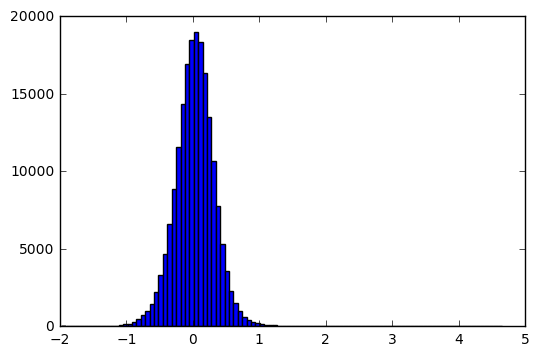

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(hdiffs0, bins=100)
plt.show()

# Differentiation in specific peaks

Restrict to cell line-specific peaks

In [14]:
print "startk562"
k562specouts = model.predict(model_input(k562seqs_spec))
print "starthepg2"
hepg2specouts = model.predict(model_input(hepg2seqs_spec))

startk562
starthepg2


In [22]:
np.asarray([sum(hepg2specouts[:,i])/float(len(hepg2seqs_spec)) for i in xrange(4)]) - np.asarray([sum(k562specouts[:,i])/float(len(k562seqs_spec)) for i in xrange(4)])

array([ 0.07544006, -0.05002364,  0.08760819, -0.01722078])

In [28]:
print sum([int(hepg2specouts[i, 0] > hepg2specouts[i, 1]) for i in xrange(len(hepg2specouts))]), len(hepg2specouts)
print sum([int(hepg2specouts[i, 2] > hepg2specouts[i, 3]) for i in xrange(len(hepg2specouts))]), len(hepg2specouts)

70829 115862
59896 115862


In [26]:
sum([int(k562specouts[i, 0] < k562specouts[i, 1]) for i in xrange(len(k562specouts))]), len(k562specouts)

(71501, 125105)

In [23]:
np.asarray([sum(hepg2outs[:,i])/float(len(hepg2seqs)) for i in xrange(4)]) - np.asarray([sum(k562outs[:,i])/float(len(k562seqs)) for i in xrange(4)])

array([ 0.04938086, -0.02909473,  0.05711121, -0.01056547])

# Against background sequences

See if model predicts enriched expression in DNase peaks compared to background regions nearby

In [89]:
hepg2seqs_bg = []
f = open(data_dir + "HepG2seqs_bg.txt")
reads = f.readlines()
f.close()
for read in reads:
    if read[0] != '>':
        read = read[:-1]
        seql = len(read)
        hepg2seqs_bg.append(read[seql/2 - 72 : seql/2 + 73].upper())

k562seqs_bg = []
f = open(data_dir + "K562seqs_bg.txt")
reads = f.readlines()
f.close()
for read in reads:
    if read[0] != '>':
        read = read[:-1]
        seql = len(read)
        k562seqs_bg.append(read[seql/2 - 72 : seql/2 + 73].upper())

In [91]:
print "startk562"
k562bgouts = model.predict(model_input(k562seqs_bg))
print "starthepg2"
hepg2bgouts = model.predict(model_input(hepg2seqs_bg))

startk562
starthepg2


In [93]:
np.asarray([sum(hepg2outs[:,i])/float(len(hepg2seqs)) for i in xrange(4)]) - np.asarray([sum(hepg2bgouts[:,i])/float(len(hepg2seqs_bg)) for i in xrange(4)])

array([ 0.01664479,  0.02442629,  0.01317806,  0.01469933])

In [94]:
np.asarray([sum(k562outs[:,i])/float(len(k562seqs)) for i in xrange(4)]) - np.asarray([sum(k562bgouts[:,i])/float(len(k562seqs_bg)) for i in xrange(4)])

array([ 0.01561683,  0.0296251 ,  0.01202066,  0.0177477 ])

In [95]:
hepg2seqs_bg_bad = []
f = open(data_dir + "HepG2seqs_bg_bad.txt")
reads = f.readlines()
f.close()
for read in reads:
    if read[0] != '>':
        read = read[:-1]
        seql = len(read)
        hepg2seqs_bg_bad.append(read[seql/2 - 72 : seql/2 + 73].upper())

k562seqs_bg_bad = []
f = open(data_dir + "K562seqs_bg_bad.txt")
reads = f.readlines()
f.close()
for read in reads:
    if read[0] != '>':
        read = read[:-1]
        seql = len(read)
        k562seqs_bg_bad.append(read[seql/2 - 72 : seql/2 + 73].upper())

In [96]:
print "startk562"
k562bgbadouts = model.predict(model_input(k562seqs_bg_bad))
print "starthepg2"
hepg2bgbadouts = model.predict(model_input(hepg2seqs_bg_bad))

startk562
starthepg2


In [97]:
np.asarray([sum(hepg2outs[:,i])/float(len(hepg2seqs)) for i in xrange(4)]) - np.asarray([sum(hepg2bgbadouts[:,i])/float(len(hepg2seqs_bg_bad)) for i in xrange(4)])

array([ 0.02093879,  0.033314  ,  0.01656636,  0.01913879])

In [101]:
means = np.asarray([-0.17303934, -0.24127505, -0.12425002, -0.06486262])

counter = 0

for out in hepg2specouts:
    rescale = np.asarray(out) - means
    if rescale[0] > rescale[1] and rescale[2] > rescale[3]:
        counter += 1
    if rescale[0] > rescale[1] and rescale[2] < rescale[3]:
        counter += 0.5
    if rescale[0] < rescale[1] and rescale[2] > rescale[3]:
        counter += 0.5

counter

61889.0

In [102]:
len(hepg2specouts)

115862